In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import optuna
from sklearn.metrics import mean_squared_error, r2_score
from cubist import Cubist

### Importing OSSL dataset

In [27]:
wet_chemistry_data = pd.read_csv('./dataset/ossl_soillab_L0_v1.2.csv')
spectral_data = pd.read_csv('./dataset/ossl_mir_L0_v1.2.csv')
soilsite_data = pd.read_csv('./dataset/ossl_soilsite_L0_v1.2.csv')

/var/folders/rn/fbg5b19n6759xrg6__m9p_sr0000gn/T/ipykernel_65860/993072437.py:1: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  wet_chemistry_data = pd.read_csv('./dataset/ossl_soillab_L0_v1.2.csv')
/var/folders/rn/fbg5b19n6759xrg6__m9p_sr0000gn/T/ipykernel_65860/993072437.py:2: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  spectral_data = pd.read_csv('./dataset/ossl_mir_L0_v1.2.csv')
/var/folders/rn/fbg5b19n6759xrg6__m9p_sr0000gn/T/ipykernel_65860/993072437.py:3: DtypeWarning: Columns (2,13,14,15,19,23,32) have mixed types. Specify dtype option on import or set low_memory=False.
  soilsite_data = pd.read_csv('./dataset/ossl_soilsite_L0_v1.2.csv')


### Merging dataset

In [28]:
merged_data = pd.merge( wet_chemistry_data, spectral_data, on='id.layer_uuid_txt')
merged_data = pd.merge( soilsite_data, merged_data, on='id.layer_uuid_txt')


In [29]:
merged_data.head()


,dataset.code_ascii_txt,id.layer_uuid_txt,id.layer_local_c,longitude.point_wgs84_dd,latitude.point_wgs84_dd,layer.sequence_usda_uint16,layer.upper.depth_usda_cm,layer.lower.depth_usda_cm,observation.date.begin_iso.8601_yyyy.mm.dd,observation.date.end_iso.8601_yyyy.mm.dd,...,scan_mir.3982_abs,scan_mir.3984_abs,scan_mir.3986_abs,scan_mir.3988_abs,scan_mir.3990_abs,scan_mir.3992_abs,scan_mir.3994_abs,scan_mir.3996_abs,scan_mir.3998_abs,scan_mir.4000_abs
0,AFSIS1.SSL,ded584d70bf0474202d30e575ae24784,icr072246,15.687492,-7.377750,1.0,0.0,20.0,2011-01-01,2013-12-31,...,0.35678,0.35664,0.35578,0.35474,0.35410,0.35366,0.35324,0.35292,0.35255,0.35205
1,AFSIS1.SSL,7c080e182bc23e19747629f46edbc6c4,icr072247,15.687492,-7.377750,2.0,20.0,50.0,2011-01-01,2013-12-31,...,0.35840,0.35814,0.35714,0.35598,0.35524,0.35472,0.35422,0.35382,0.35338,0.35280
2,AFSIS1.SSL,03bbd570dfd399bfd866ebcdf860de39,icr072266,15.687817,-7.351243,1.0,0.0,20.0,2011-01-01,2013-12-31,...,0.37252,0.37234,0.37142,0.37034,0.36968,0.36924,0.36881,0.36847,0.36808,0.36756
3,AFSIS1.SSL,887d316328ef950eeca33293bfe052bf,icr072267,15.687817,-7.351243,2.0,20.0,50.0,2011-01-01,2013-12-31,...,0.35799,0.35773,0.35671,0.35548,0.35468,0.35414,0.35362,0.35322,0.35276,0.35216
4,AFSIS1.SSL,ca03ce6e439b1909c5a4a771c0afa951,icr072286,15.687965,-7.331673,1.0,0.0,20.0,2011-01-01,2013-12-31,...,0.31625,0.31609,0.31510,0.31391,0.31321,0.31276,0.31231,0.31197,0.31157,0.31104


### Getting spectral and target colums name

In [30]:
spectral_columns = [col for col in merged_data.columns if 'scan_mir' in col]
target_column = 'oc_usda.c729_w.pct'

### Cleaning the Dataset and splitting features and target

In [32]:

## Removing null values
cleaned_data = merged_data.dropna(subset=spectral_columns + [target_column])


## Taking data from 10th Percentile to 90th percentile for removing outliers
q_low = cleaned_data[target_column].quantile(0.1)
q_hi  = cleaned_data[target_column].quantile(0.9)
cleaned_data_filtered = cleaned_data[(cleaned_data[target_column] < q_hi) & (cleaned_data[target_column] > q_low)]

print(cleaned_data.shape)

print(cleaned_data_filtered.shape)
## Taking sample data for feature and target split
sampled_data = cleaned_data_filtered

X = sampled_data[spectral_columns]
y = sampled_data[target_column]

## Taking sample for optimizing the algorithm
sampled_data_h = cleaned_data_filtered.sample(n=1000, random_state=42)
X_h = sampled_data_h[spectral_columns]
y_h = sampled_data_h[target_column]



(55900, 1824)
(44426, 1824)


### Splitting Training and Testing data

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_h, y_h, test_size=0.2, random_state=42)


### Function for optimizing hyperparameters (neighbors, commmittees) for Cubist Model

In [34]:
def objective(trial):
    committees = trial.suggest_int('committees', 1, 20)
    neighbors = trial.suggest_int('neighbors', 1, 9)

    model = Cubist()
    model.neighbors = neighbors
    model.n_committees = committees
    model.fit(X_train_h, y_train_h)
    y_pred_h = model.predict(X_test_h)
    
    # Evaluate using RMSE
    rmse = mean_squared_error(y_test_h, y_pred_h, squared=False)
    return rmse

In [35]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

[I 2024-06-11 08:56:26,860] A new study created in memory with name: no-name-df426c80-3d9b-4ddd-b798-8ffaa90369d0


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-11 08:56:47,783] Trial 0 finished with value: 0.4666029018899864 and parameters: {'committees': 16, 'neighbors': 3}. Best is trial 0 with value: 0.4666029018899864.
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-11 08:57:06,701] Trial 1 finished with value: 0.4734250752846822 and parameters: {'committees': 14, 'neighbors': 5}. Best is trial 0 with value: 0.4666029018899864.
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in v

In [36]:
best_params = study.best_params
print(f'Best hyperparameters: {best_params}')


Best hyperparameters: {'committees': 18, 'neighbors': 3}


## Training the final model

In [37]:
model = Cubist()
model.neighbors = best_params["neighbors"]  
model.n_committees = best_params["committees"]

final_model = model.fit(X_train, y_train)

In [38]:
import joblib

# Save the trained model to a file
joblib.dump(final_model, 'organic_carbon_cubist_model_44k_OSSL_mir.joblib')


['organic_carbon_cubist_model_44k_OSSL_mir.joblib']

## Testing the Final Model and Evaluating

In [40]:
y_pred = final_model.predict(X_test)

# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

def lccc(y_true, y_pred):
    pearson_corr = np.corrcoef(y_true, y_pred)[0, 1]
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)

    numerator = 2 * pearson_corr * sd_true * sd_pred
    denominator = var_true + var_pred + (mean_true - mean_pred) ** 2

    return numerator / denominator

lccc_value = lccc(y_test, y_pred)

print(f'R^2: {r2}')
print                   (f'RMSE: {rmse}')
print(f'LCCC: {lccc_value}')

R^2: 0.9495037466132024
RMSE: 0.37175445970053717
LCCC: 0.9741445924293898


In [46]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)


print(f'MAPE: {mape}%')

MAPE: 17.383158585693977%


## Plotting the results

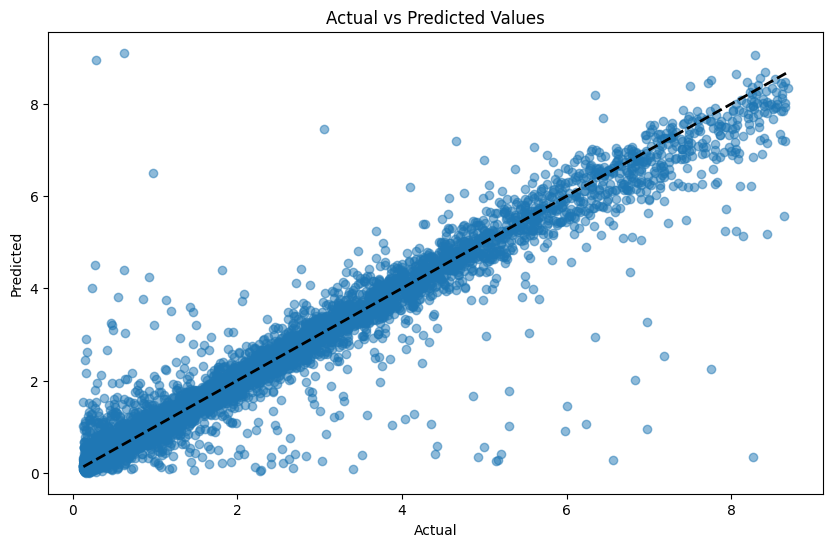

In [47]:
import matplotlib.pyplot as plt

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.show()


